<a href="https://colab.research.google.com/github/PhoeniX-Y/Plant-disease_grape_Colab/blob/main/planty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow efficientnet

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
base_dir = '/content/drive/MyDrive/Grape'
train_dir = f'{base_dir}/Train'
val_dir = f'{base_dir}/Val'
test_dir = f'{base_dir}/Test'

# Set image size and batch size
img_size = (224, 224)
batch_size = 32

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)

Found 7232 images belonging to 4 classes.
Found 1623 images belonging to 4 classes.
Found 182 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

def create_model(num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    for layer in base_model.layers:
        layer.trainable = False

    return model

model = create_model(num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=5,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/5
226/226 [==============================] - ETA: 0s - loss: 1.4029 - accuracy: 0.2609 
Epoch 1: val_accuracy improved from -inf to 0.26063, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


226/226 [==============================] - 3082s 14s/step - loss: 1.4029 - accuracy: 0.2609 - val_loss: 1.4259 - val_accuracy: 0.2606 - lr: 0.0010
Epoch 2/5
226/226 [==============================] - ETA: 0s - loss: 1.3887 - accuracy: 0.2641
Epoch 2: val_accuracy improved from 0.26063 to 0.26438, saving model to best_model.h5
226/226 [==============================] - 128s 566ms/step - loss: 1.3887 - accuracy: 0.2641 - val_loss: 1.3903 - val_accuracy: 0.2644 - lr: 0.0010
Epoch 3/5
226/226 [==============================] - ETA: 0s - loss: 1.3873 - accuracy: 0.2631
Epoch 3: val_accuracy improved from 0.26438 to 0.26562, saving model to best_model.h5
226/226 [==============================] - 127s 561ms/step - loss: 1.3873 - accuracy: 0.2631 - val_loss: 1.3856 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 4/5
226/226 [==============================] - ETA: 0s - loss: 1.3855 - accuracy: 0.2670
Epoch 4: val_accuracy improved from 0.26562 to 0.26625, saving model to best_model.h5
226/226 [=====

6/6 [==============================] - 55s 11s/step - loss: 1.3850 - accuracy: 0.2637
Test accuracy: 0.2637
6/6 [==============================] - 2s 135ms/step


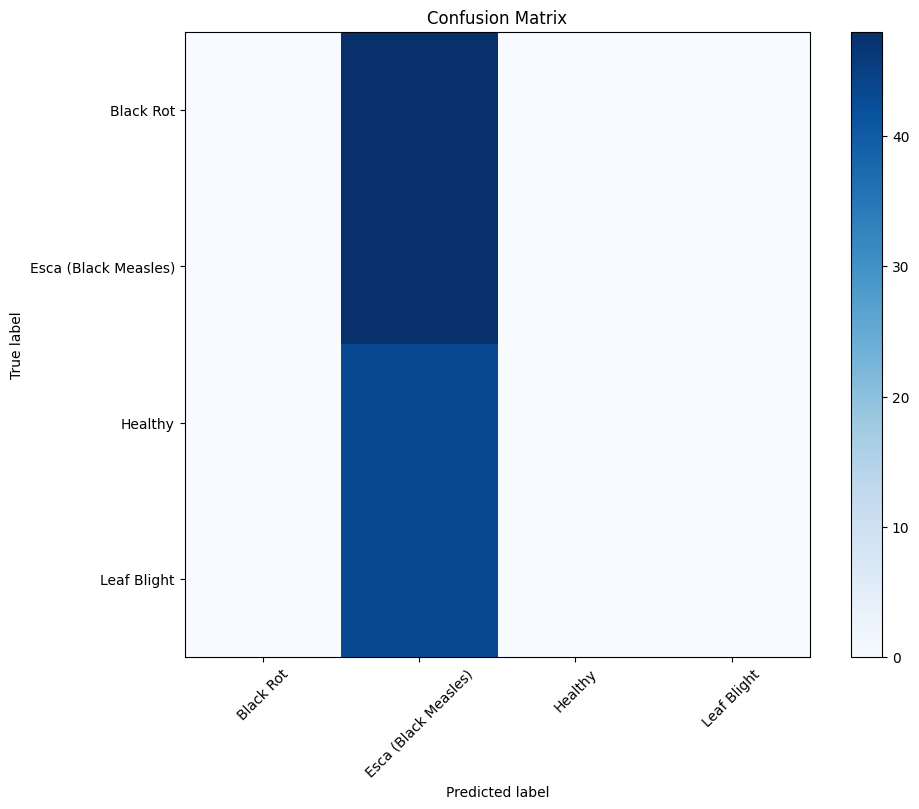

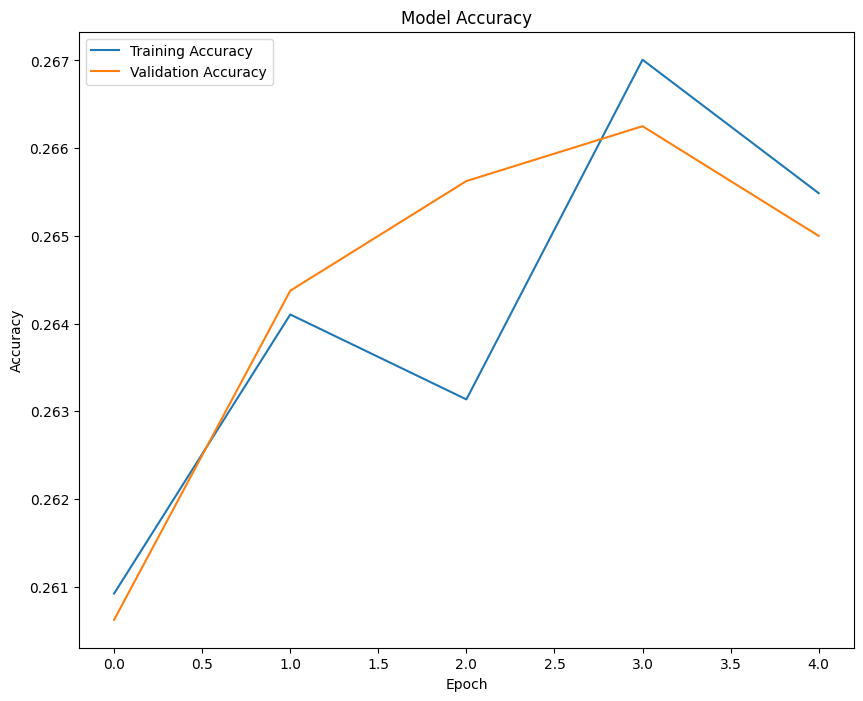

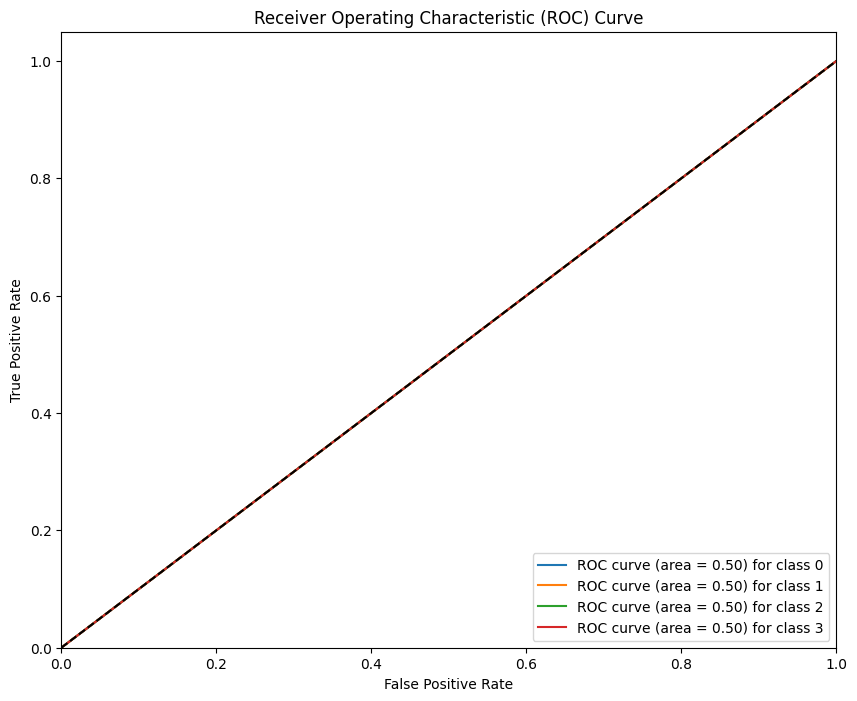

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy import interp

# Load best model
model.load_weights('best_model.h5')

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

# Predict on test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Accuracy plot
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
!pip install gradio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.3 M

In [ ]:
!pip install --upgrade gradio

In [ ]:
import tensorflow as tf
import numpy as np
import gradio as gr
import json

# Load disease information
with open('grape_plant_info.json', 'r') as f:
    disease_info = json.load(f)

# Load your trained model (replace 'your_model.h5' with your actual model file)
model = tf.keras.models.load_model('best_model.h5')

def predict_disease(image, plant):
    # Preprocess the image
    img = tf.keras.preprocessing.image.img_to_array(image)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    img = tf.expand_dims(img, 0)

    # Make prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])

    class_names = ['Grape Black Rot', 'Grape Esca (Black Measles)', 'Grape Leaf Blight (Isariopsis Leaf Spot)', 'Healthy Grape']
    predicted_disease = class_names[predicted_class]

    # Get disease information
    info = disease_info.get(predicted_disease, {})
    symptoms = info.get('symptoms', 'Information not available')
    prevention = info.get('prevention', 'Information not available')
    remedies = info.get('remedies', 'Information not available')

    result = f"Predicted Disease: {predicted_disease}\nConfidence: {confidence:.2f}\n\n"
    result += f"Symptoms:\n{symptoms}\n\n"
    result += f"Prevention:\n{prevention}\n\n"
    result += f"Remedies:\n{remedies}"

    return result

# Create Gradio interface
iface = gr.Interface(
    fn=predict_disease,
    inputs=[
        gr.Image(type="pil"),
        gr.Dropdown(choices=['Grape'], label="Plant Type")
    ],
    outputs=gr.Textbox(),
    title="Plant Disease Prediction",
    description="Upload an image of a plant leaf to predict the disease."
)

iface.launch(share=True)


AttributeError: module 'gradio' has no attribute 'Request'

In [ ]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.4 MB/s eta 0:00:00


In [ ]:
%%writefile app.py

import streamlit as st
import tensorflow as tf
import numpy as np
import json
from PIL import Image

# Load disease information
with open('grape_plant_info.json', 'r') as f:
    disease_info = json.load(f)

# Load your trained model (replace 'your_model.h5' with your actual model file)
model = tf.keras.models.load_model('best_model.h5')

class_names = ['Grape Black Rot', 'Grape Esca (Black Measles)', 'Grape Leaf Blight (Isariopsis Leaf Spot)', 'Healthy Grape']

def predict_disease(image):
    # Preprocess the image
    img = tf.keras.preprocessing.image.img_to_array(image)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    img = tf.expand_dims(img, 0)

    # Make prediction
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])

    predicted_disease = class_names[predicted_class]

    # Get disease information
    info = disease_info.get(predicted_disease, {})
    symptoms = info.get('symptoms', 'Information not available')
    prevention = info.get('prevention', 'Information not available')
    remedies = info.get('remedies', 'Information not available')

    result = {
        "Predicted Disease": predicted_disease,
        "Confidence": confidence,
        "Symptoms": symptoms,
        "Prevention": prevention,
        "Remedies": remedies
    }

    return result

# Streamlit UI
st.title("Plant Disease Prediction")

uploaded_file = st.file_uploader("Choose an image of a plant leaf...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    result = predict_disease(image)

    st.write(f"**Predicted Disease:** {result['Predicted Disease']}")
    st.write(f"**Confidence:** {result['Confidence']:.2f}")
    st.write(f"**Symptoms:** {result['Symptoms']}")
    st.write(f"**Prevention:** {result['Prevention']}")
    st.write(f"**Remedies:** {result['Remedies']}")


Writing app.py


In [ ]:
!ngrok authtoken 2iax8LnaBlRFVuvFRdEwUyRUWwP_yaozqvxtBRNM42QADemT

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!pip install pyngrok
from pyngrok import ngrok
ngrok.set_auth_token("<YOUR_AUTHTOKEN>")

In [ ]:
from pyngrok import ngrok

# Start ngrok tunnel
public_url = ngrok.connect(port='8501')
public_url


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [ ]:
from pyngrok import ngrok

# Start ngrok tunnel, specifying the port within the 'config' section for an HTTP tunnel
tunnel = ngrok.connect(8501, "http")
public_url = tunnel.public_url
print(public_url)

https://b379-34-125-96-166.ngrok-free.app


In [ ]:
!streamlit run app.py &>/content/logs.txt &
